Cloning into 'Amthal'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 101 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 2.84 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Amthal/Amthal
Data loaded successfully. Found 4078 instances.



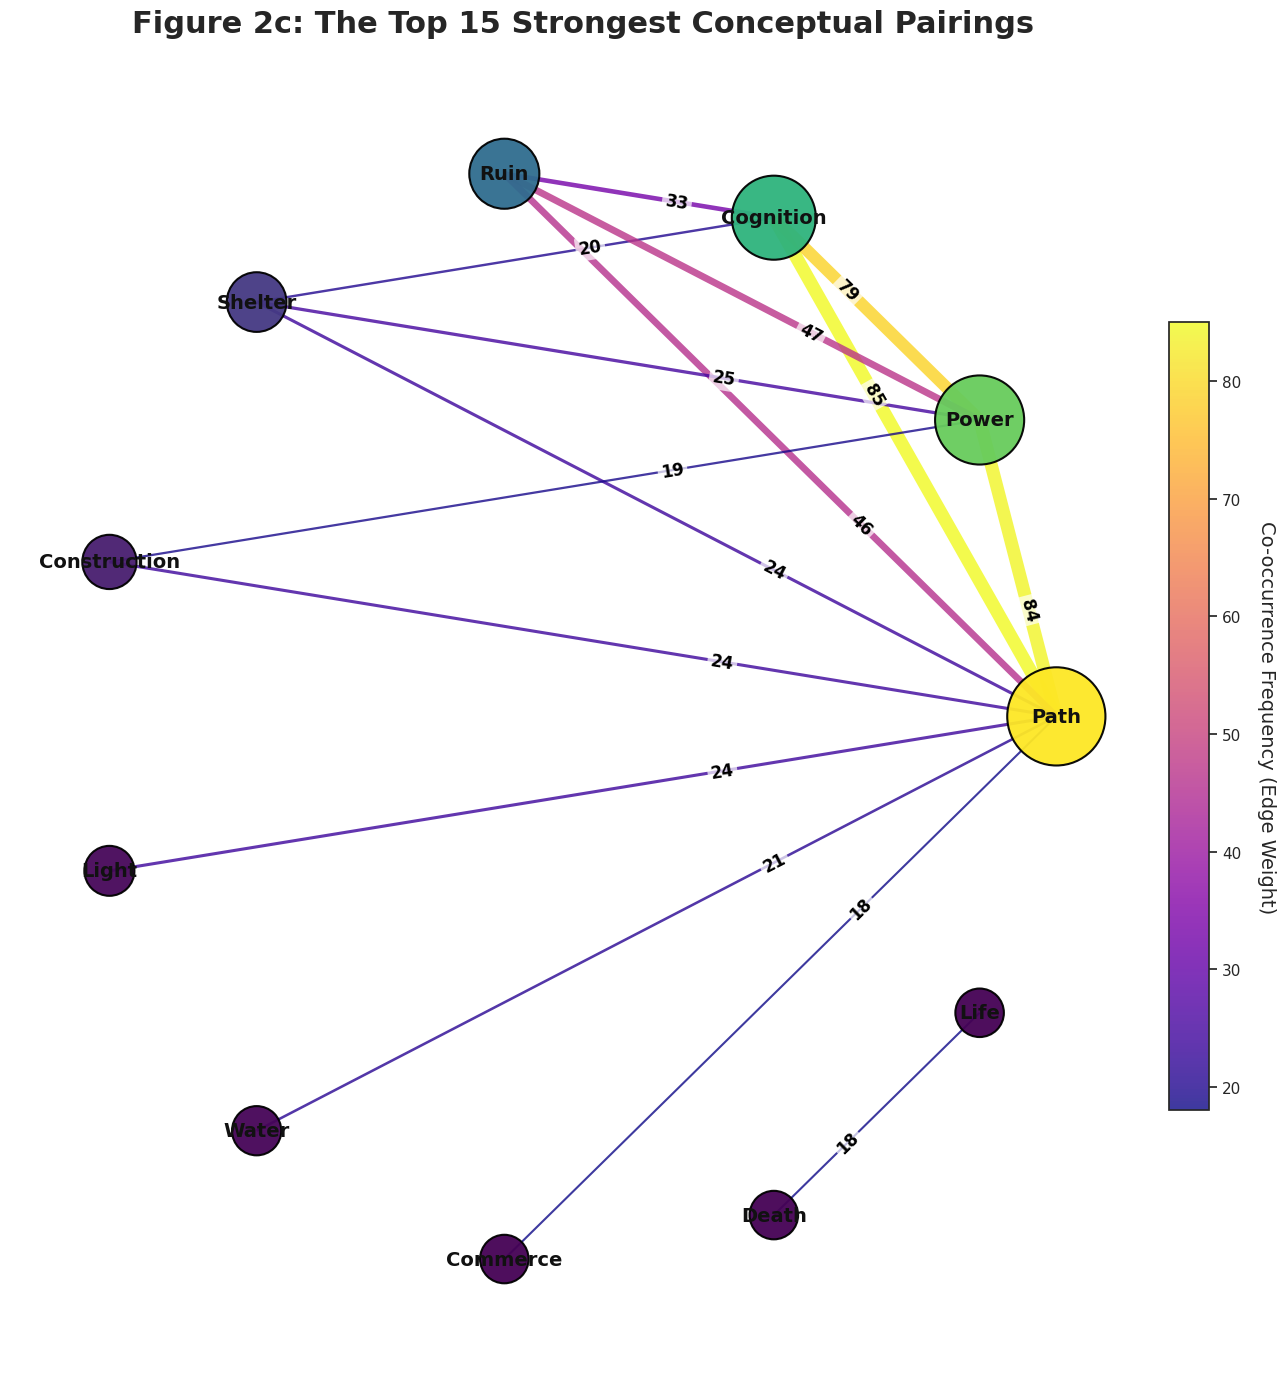

In [2]:
#@title  **The Top 15 Strongest Conceptual Pairings**


# --- إعداد عام ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal

from utility import *
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
import warnings

# تجاهل التحذيرات الخاصة بالخطوط
warnings.filterwarnings("ignore", message=".*font_manager.*")

# تعيين خط متوفر في كل بيئات matplotlib
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]

# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]
    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()





# (كود بناء edge_weights)
grouped = df.groupby(['Sura_No', 'Aya_No'])['Dominant_Concept'].apply(list)
edges = []
for concepts in grouped:
    if len(concepts) > 1:
        for combo in combinations(set(concepts), 2):
            edges.append(tuple(sorted(combo)))
edge_weights = pd.DataFrame(edges, columns=['source', 'target'])
edge_weights = edge_weights.value_counts().reset_index(name='weight')


# --- 2. فلترة البيانات للحصول على أقوى العلاقات ---
TOP_N_EDGES = 15
top_edges_df = edge_weights.sort_values(by='weight', ascending=False).head(TOP_N_EDGES)


# --- 3. بناء الشبكة وحساب الخصائص ---
G_top = nx.from_pandas_edgelist(top_edges_df, 'source', 'target', ['weight'])
degrees_top = dict(G_top.degree(weight='weight'))
# تحسين مقياس حجم العقدة
max_degree = max(degrees_top.values()) if degrees_top else 1
node_sizes = [1000 + (degrees_top.get(n, 0) / max_degree) * 4000 for n in G_top.nodes()]

weights = nx.get_edge_attributes(G_top, 'weight')
min_w, max_w = min(weights.values()), max(weights.values())
edge_widths = [1.5 + (w - min_w) / (max_w - min_w) * 8 for w in weights.values()]


# --- 4. تحديد مواقع العقد (Layout) ---
# فرز العقد بناءً على درجتها قبل تمريرها إلى التخطيط الدائري
# هذا يضع العقد الأكثر أهمية بجانب بعضها البعض، مما يجعل الرسم أكثر تنظيمًا
sorted_nodes = sorted(degrees_top, key=degrees_top.get, reverse=True)
pos = nx.circular_layout(sorted_nodes)



# --- 5. الرسم الاحترافي ---
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.set_title(f'Figure 2c: The Top {TOP_N_EDGES} Strongest Conceptual Pairings',
             fontsize=22, fontweight='bold', pad=20)

# رسم الروابط أولاً
# استخدام تدرج لوني للروابط لإبراز الأقوى
edge_colors = [w['weight'] for u, v, w in G_top.edges(data=True)]
edges = nx.draw_networkx_edges(
    G_top,
    pos,
    width=edge_widths,
    edge_cmap=plt.cm.plasma, # تدرج لوني جذاب
    edge_color=edge_colors,
    alpha=0.8,
    ax=ax
)

# رسم العقد
node_colors = [degrees_top[n] for n in G_top.nodes()]
nodes = nx.draw_networkx_nodes(
    G_top,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.95,
    ax=ax
)
nodes.set_edgecolor('black')
nodes.set_linewidth(1.5)

# رسم تسميات العقد (بطريقة تتجنب التداخل)
nx.draw_networkx_labels(
    G_top,
    pos,
    font_size=14,
    font_weight='bold',
    font_color='#111111',
    ax=ax
)

# رسم أوزان الروابط (مع تحسينات لتجنب التداخل)
# label_pos يزيح التسمية قليلاً عن منتصف الرابط
edge_labels = nx.get_edge_attributes(G_top, 'weight')
nx.draw_networkx_edge_labels(
    G_top,
    pos,
    edge_labels=edge_labels,
    font_color='black',
    font_size=12,
    font_weight='bold',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'),
    label_pos=0.35, # إزاحة التسمية على طول الرابط
    ax=ax
)


# --- 6. التنسيق النهائي والحفظ ---
# إضافة مفتاح لوني للروابط
cbar = plt.colorbar(edges, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('Co-occurrence Frequency (Edge Weight)', rotation=270, labelpad=25, fontsize=14)

ax.axis('off')
plt.tight_layout()
plt.savefig('Figure_2c_Top_Edges_Network_Pro.png', dpi=300, bbox_inches='tight')
plt.show()